In [11]:
import pandas as pd
from pandas import read_csv
import biogeme.database as db
import biogeme.biogeme as bio
import biogeme.models as models
from biogeme.expressions import Beta, DefineVariable, Derive, log
import math
import random
import biogeme.results as res
from random import randint
import os, inspect
from sklearn.utils import shuffle
import numpy as np
import scipy.stats as s

import warnings
warnings.filterwarnings("ignore")

path_to_prj = '/Users/xiaodanxu/Library/CloudStorage/GoogleDrive-arielinseu@gmail.com/My Drive/GEMS/BILD-AQ/data'
os.chdir(path_to_prj)
# selected_region = 'CD9'
input_dir = 'Input/'

In [2]:
raw_data = pd.read_csv(input_dir + 'NHTS_car_trips.csv')
print(raw_data.columns)
raw_data = raw_data.dropna()
raw_data[['home_geoid', 'o_geoid', 'd_geoid']] = \
raw_data[['home_geoid', 'o_geoid', 'd_geoid']].astype(int)
raw_data.loc[:, 'trip_id'] = raw_data.reset_index().index + 1
print(len(raw_data))
raw_data.head(5)

Index(['home_geoid', 'o_geoid', 'd_geoid', 'o_geotype', 'o_microtype',
       'dest_geotype', 'dest_microtype', 'populationGroupType', 'trip_tag',
       'start hour', 'travel time', 'trip_purpose', 'trpmiles', 'distanceBin',
       'wtperfin', 'FID', 'GEOID', 'MicrotypeID', 'microtype', 'microtype_imp',
       'fips_st', 'st_code', 'state', 'cty', 'ctyname', 'cbsa', 'cbsaname',
       'spatial_id', 'geotype', 'geotype_imp'],
      dtype='object')
753968


,home_geoid,o_geoid,d_geoid,o_geotype,o_microtype,dest_geotype,dest_microtype,populationGroupType,trip_tag,start hour,...,st_code,state,cty,ctyname,cbsa,cbsaname,spatial_id,geotype,geotype_imp,trip_id
0,37191001301,37191001301,37191001200,E,4.0,E,4.0,medium-income,origin,10.000000,...,NC,North Carolina,37191.0,"Wayne County, NC",24140.0,"Goldsboro, NC",24140.0,E,False,1
1,37191001301,37191001200,37191001301,E,4.0,E,4.0,medium-income,dest,15.166667,...,NC,North Carolina,37191.0,"Wayne County, NC",24140.0,"Goldsboro, NC",24140.0,E,False,2
2,37191001301,37183053717,37191001301,C,3.0,C,3.0,medium-income,dest,7.000000,...,NC,North Carolina,37191.0,"Wayne County, NC",24140.0,"Goldsboro, NC",24140.0,E,False,3
3,37191001301,37191001301,37183053717,E,4.0,C,3.0,medium-income,origin,18.000000,...,NC,North Carolina,37191.0,"Wayne County, NC",24140.0,"Goldsboro, NC",24140.0,E,False,4
4,37191001301,37191001301,37191001302,E,4.0,E,5.0,medium-income,origin,8.750000,...,NC,North Carolina,37191.0,"Wayne County, NC",24140.0,"Goldsboro, NC",24140.0,E,False,5


In [6]:
# load additional data

microtype_lookup_file = 'ccst_geoid_key_tranps_geo_with_imputation.csv'
microtype_lookup = pd.read_csv('Network/' + microtype_lookup_file, sep = ',')
microtype_lookup_short = microtype_lookup[['GEOID', 'st_code', 'geotype', 'microtype']]
microtype_lookup_short['GEOID'] = microtype_lookup_short['GEOID'].astype(int)

# load size term (employment size, accessibility, etc)
employment_file = 'wac_tract_2017.csv'
employment_data = pd.read_csv('Network/' + employment_file, sep = ',')
employment_data_short = employment_data[['trct',  'jobs_total']]
# print(employment_data_short.head(5))

opportunity_file = 'opportunity_counts_tract.csv'
opportunity_data = pd.read_csv('Network/' + opportunity_file, sep = ',')
# opportunity_data.head(5)

mode_availability_file = 'modeaccessibility.csv'
mode_availability = pd.read_csv('Network/' + mode_availability_file, sep = ',')
mode_availability.head(5)


,Unnamed: 0,geoid,bike,rail,bus
0,1,1001020100,0,0,0
1,2,1001020200,0,1,0
2,3,1001020300,0,0,0
3,4,1001020400,0,0,0
4,5,1001020500,0,0,0


In [5]:
# construct data for mode choice
import matplotlib.pyplot as plt

raw_data = raw_data.loc[raw_data['trip_tag'] != 'nhb']
raw_data.loc[:, 'orig_geoid'] = raw_data.loc[:, 'home_geoid']
raw_data.loc[:, 'dest_geoid'] = raw_data.loc[:, 'd_geoid']

# raw_data = raw_data.loc[raw_data['st_code'].isin(['OR', 'WA'])] # TEST SUBSET

# raw_data.loc[raw_data['trip_tag'] == 'dest', 'orig_geoid'] = raw_data.loc[:, 'home_geoid']
raw_data.loc[raw_data['trip_tag'] == 'dest', 'dest_geoid'] = \
raw_data.loc[:, 'o_geoid']
training_data = raw_data[['trip_id', 'orig_geoid', 'dest_geoid', 'dest_geotype', 'wtperfin',
                          'dest_microtype', 'trip_purpose', 'populationGroupType']]
training_data = training_data.dropna()
print(training_data.isnull().values.any())
sample_training_data = training_data.sample(n=30000, replace=False)
sample_training_data.head(10)

False


,trip_id,orig_geoid,dest_geoid,dest_geotype,wtperfin,dest_microtype,trip_purpose,populationGroupType
21640,20470,51510200103,51041101007,B,10363.531485,4.0,home,medium-income
443767,418735,34035053501,34035054300,A,3304.539430,4.0,leisure,medium-income
308497,291040,36029011200,36029014102,B,351.597042,4.0,home,low-income
54539,51556,19013002500,19013001301,B,10.237519,2.0,medical,medium-income
574080,542067,12086003917,12086003913,A,13525.423097,1.0,leisure,low-income
660475,623732,8035014133,8035014133,B,4941.716101,5.0,home,medium-income
495701,467818,13135050724,13135050721,F,234.520482,5.0,leisure,low-income
498626,470646,6061021123,6061021122,B,521.128283,5.0,leisure,high-income
433603,409076,6037800326,6037800327,A,1109.589250,3.0,home,high-income
86046,81266,6025011300,6025011300,B,3225.014581,6.0,home,medium-income


In [9]:
# assign state ID for home/origin tracts
chosen_data = pd.merge(sample_training_data, microtype_lookup_short,
                       left_on = 'orig_geoid', right_on = 'GEOID',
                       how = 'left')
chosen_data = chosen_data.drop(columns = ['GEOID'])
chosen_data = \
chosen_data.rename(columns = {'geotype': 'orig_geotype',
                              'microtype': 'orig_microtype'})
seleted_states = chosen_data.st_code.unique()
print(len(seleted_states))
print(seleted_states)
chosen_data.head(5)

51
['VA' 'NJ' 'NY' 'IA' 'FL' 'CO' 'GA' 'CA' 'NC' 'TX' 'UT' 'PA' 'SC' 'WI'
 'AZ' 'NM' 'OR' 'OK' 'IN' 'MS' 'KS' 'MT' 'TN' 'MD' 'OH' 'WA' 'AK' 'NE'
 'IL' 'MA' 'MN' 'MI' 'WV' 'HI' 'SD' 'ME' 'ND' 'AL' 'ID' 'RI' 'WY' 'NH'
 'VT' 'KY' 'MO' 'NV' 'AR' 'DE' 'LA' 'CT' 'DC']


,trip_id,orig_geoid,dest_geoid,dest_geotype,wtperfin,dest_microtype,trip_purpose,populationGroupType,st_code,orig_geotype,orig_microtype
0,20470,51510200103,51041101007,B,10363.531485,4.0,home,medium-income,VA,A,2
1,418735,34035053501,34035054300,A,3304.539430,4.0,leisure,medium-income,NJ,A,3
2,291040,36029011200,36029014102,B,351.597042,4.0,home,low-income,NY,B,5
3,51556,19013002500,19013001301,B,10.237519,2.0,medical,medium-income,IA,B,2
4,542067,12086003917,12086003913,A,13525.423097,1.0,leisure,low-income,FL,A,2


In [23]:
chosen_data_out = None
for st in seleted_states:
    print(st)
    chosen_data_by_state = \
    chosen_data.loc[chosen_data['st_code'] == st]
    dist_matrix_file = \
    'Network/' + st + '/travel_time_skim.csv'
    dist_matrix_long = read_csv(dist_matrix_file)
    dist_matrix_long[['origin', 'destination']] = \
    dist_matrix_long[['origin', 'destination']].astype(int)
#     print(len(chosen_data_by_state))
    chosen_data_by_state = \
    pd.merge(chosen_data_by_state, 
             dist_matrix_long,
             left_on = ['orig_geoid', 'dest_geoid'],
             right_on = ['origin', 'destination'],
             how = 'inner')
    chosen_data_by_state.loc[:,'chosen'] = 1
    chosen_data_by_state = chosen_data_by_state[['trip_id', 'orig_geoid', 'st_code',
                                                 'dest_geoid', 'dest_geotype', 'wtperfin',
                                                 'dest_microtype',	'trip_purpose', 
                                                 'populationGroupType', 
                                                 'distance_mile', 'travel_time_h', 
                                                 'chosen']]
    chosen_data_out = pd.concat([chosen_data_out, chosen_data_by_state])
print(len(chosen_data_out))
chosen_data_out.head(5)

VA
NJ
NY
IA
FL
CO
GA
CA
NC
TX
UT
PA
SC
WI
AZ
NM
OR
OK
IN
MS
KS
MT
TN
MD
OH
WA
AK
NE
IL
MA
MN
MI
WV
HI
SD
ME
ND
AL
ID
RI
WY
NH
VT
KY
MO
NV
AR
DE
LA
CT
DC
29438


,trip_id,orig_geoid,st_code,dest_geoid,dest_geotype,wtperfin,dest_microtype,trip_purpose,populationGroupType,distance_mile,travel_time_h,chosen
0,643397,51810044600,VA,51810043002,E,1719.330888,5.0,home,high-income,3.042593,0.185222,1
1,233516,51760050500,VA,51087200407,B,3882.445539,2.0,leisure,high-income,5.556727,0.313273,1
2,599974,51085321002,VA,51087200407,B,3037.924159,2.0,home,low-income,17.644617,0.515433,1
3,422608,51760020500,VA,51085321100,B,18172.938108,3.0,other,low-income,9.883270,0.367234,1
4,422615,51760020500,VA,51085321100,B,18172.938108,3.0,other,low-income,9.883270,0.367234,1


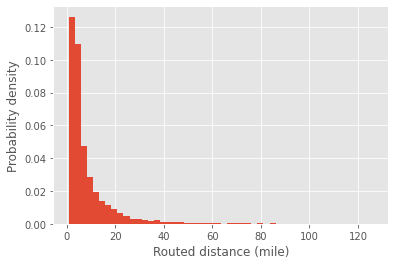

In [24]:
plt.style.use('ggplot')
chosen_data_out['distance_mile'].plot(kind="hist", 
                                      weights = chosen_data_out["wtperfin"], 
                                      bins = 50, density = True)
plt.xlabel('Routed distance (mile)')
plt.ylabel('Probability density')
plt.savefig('Plot/National/car_trip_distance_routed.png', dpi = 200)
plt.show()
# chosen_data.head(5)

VA
NJ
NY
IA
FL
CO
GA
CA
NC
TX
UT
PA
SC
WI
AZ
NM
OR
OK
IN
MS
KS
MT
TN
MD
OH
WA
AK
NE
IL
MA
MN
MI
WV
HI
SD
ME
ND
AL
ID
RI
WY
NH
VT
KY
MO
NV
AR
DE
LA
CT
DC
269397


<Axes: ylabel='Frequency'>

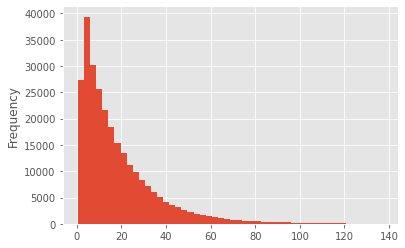

In [30]:
# create random sample for non-chosen destinations
# power_coeff = 1.05 # for comparison 
params = [1, 1.136, 0, 0.354] # fitted Weibull parameters 

non_chosen_data = chosen_data[['trip_id', 'orig_geoid', 'st_code', 'dest_geotype', 
                          'dest_microtype',	'trip_purpose', 'populationGroupType']].copy()
non_chosen_data_out = None
for st in seleted_states:
    print(st)
    non_chosen_data_by_state = \
    non_chosen_data.loc[non_chosen_data['st_code'] == st]
#     print(len(non_chosen_data_by_state))
    dist_matrix_file = \
    'Network/' + st + '/travel_time_skim.csv'
    dist_matrix_long = read_csv(dist_matrix_file)
    dist_matrix_long[['origin', 'destination']] = \
    dist_matrix_long[['origin', 'destination']].astype(int)
    dist_matrix_long = pd.merge(dist_matrix_long,
                                microtype_lookup_short,
                                left_on = 'destination',
                                right_on = 'GEOID',
                                how = 'left')
    dist_matrix_long = \
    dist_matrix_long.drop(columns = ['GEOID', 'st_code'])
    non_chosen_data_by_state = \
    pd.merge(non_chosen_data_by_state, 
             dist_matrix_long,
             left_on = ['orig_geoid', 'dest_geotype', 'dest_microtype'],
             right_on = ['origin', 'geotype', 'microtype'],
             how = 'inner')
#     print(len(non_chosen_data))
    grouping_var = ['trip_id', 'orig_geoid']

    # define location selection criteria
    non_chosen_data_by_state.loc[:, 'probability'] = \
    s.exponweib.sf(non_chosen_data_by_state.loc[:, 'travel_time_h'], *params)

    # non_chosen_data.loc[:, 'probability'] = 1 / ((non_chosen_data.loc[:, 'distance_mile'] + 1) ** power_coeff)
    # print(non_chosen_data[['travel_time_h', 'probability']].head(20))
    non_chosen_data_by_state = \
    non_chosen_data_by_state.groupby(grouping_var).sample(n=9, replace = True, 
                                                 weights = non_chosen_data_by_state['probability'], random_state=1)

    non_chosen_data_by_state.loc[:, 'chosen'] = 0
    non_chosen_data_by_state = \
    non_chosen_data_by_state[['trip_id', 'orig_geoid', 'st_code',
                              'destination', 'dest_geotype', 
                              'dest_microtype',	'trip_purpose', 'populationGroupType', 
                               'distance_mile', 'travel_time_h', 'chosen']]
    non_chosen_data_by_state = \
    non_chosen_data_by_state.rename(columns = {'destination': 'dest_geoid'})
    non_chosen_data_out = pd.concat([non_chosen_data_out, non_chosen_data_by_state])
    
#     break

print(len(non_chosen_data_out))
non_chosen_data_out.head(5)
non_chosen_data_out['distance_mile'].plot(kind="hist", bins = 50)

In [33]:
# combine data and create a training set
destination_choice_data = pd.concat([chosen_data_out, non_chosen_data_out])
destination_choice_data = shuffle(destination_choice_data)
print(len(destination_choice_data))
destination_choice_data = destination_choice_data.sort_values('trip_id')
# append size term 
destination_choice_data = pd.merge(destination_choice_data, 
                                   employment_data_short,
                                   left_on = 'dest_geoid',
                                   right_on = 'trct',
                                   how = 'left')
                                   
destination_choice_data['alternative'] = \
destination_choice_data.groupby('trip_id').cumcount() + 1
destination_choice_data['choice'] = 0
destination_choice_data.loc[destination_choice_data['chosen'] == 1, 'choice'] = \
destination_choice_data.loc[destination_choice_data['chosen'] == 1, 'alternative']

destination_choice_data.head(20)

298835


,trip_id,orig_geoid,st_code,dest_geoid,dest_geotype,wtperfin,dest_microtype,trip_purpose,populationGroupType,distance_mile,travel_time_h,chosen,trct,jobs_total,alternative,choice
0,3,37191001301,NC,37183054114,C,NaN,3.0,home,medium-income,53.051916,1.087286,0,3.718305e+10,542.0,1,0
1,3,37191001301,NC,37101040400,C,NaN,3.0,home,medium-income,21.861198,0.532872,0,3.710104e+10,500.0,2,0
2,3,37191001301,NC,37001020701,C,NaN,3.0,home,medium-income,119.992578,2.169258,0,3.700102e+10,6117.0,3,0
3,3,37191001301,NC,37085070200,C,NaN,3.0,home,medium-income,46.513582,0.870741,0,3.708507e+10,1382.0,4,0
4,3,37191001301,NC,37183053807,C,NaN,3.0,home,medium-income,68.034989,1.303600,0,3.718305e+10,1402.0,5,0
5,3,37191001301,NC,37183052302,C,NaN,3.0,home,medium-income,63.948256,1.480741,0,3.718305e+10,4480.0,6,0
6,3,37191001301,NC,37101040100,C,NaN,3.0,home,medium-income,25.585531,0.570515,0,3.710104e+10,1848.0,7,0
7,3,37191001301,NC,37101040400,C,NaN,3.0,home,medium-income,21.861198,0.532872,0,3.710104e+10,500.0,8,0
8,3,37191001301,NC,37183053717,C,197.075742,3.0,home,medium-income,74.132989,1.376481,1,3.718305e+10,4483.0,9,9
9,3,37191001301,NC,37183052404,C,NaN,3.0,home,medium-income,63.242237,1.241785,0,3.718305e+10,605.0,10,0


In [35]:
# check count of alternatives
destination_choice_data.loc[:, 'alt_count'] = destination_choice_data.groupby('trip_id')['alternative'].transform('count')
print(destination_choice_data.alt_count.unique())
destination_choice_data = \
destination_choice_data.loc[destination_choice_data['alt_count'] == 10]
print(len(destination_choice_data))

[10]
294360


In [36]:
# append opportunity count
# opportunity_data.head(5)
opportunity_data.loc[:, 'num_edu'] = opportunity_data.loc[:, 'num_schools'] + \
opportunity_data.loc[:, 'num_jrcollege'] + opportunity_data.loc[:, 'num_childcare']

opportunity_data.loc[:, 'num_med'] = opportunity_data.loc[:, 'num_hosp'] + \
opportunity_data.loc[:, 'num_pharm'] + opportunity_data.loc[:, 'num_urgentcare']

opportunity_data.loc[:, 'num_ent'] = \
opportunity_data.loc[:, 'num_parks'] 

opportunity_data_short = opportunity_data[['GEOID', 'num_edu', 'num_med', 'num_ent']]

destination_choice_data = pd.merge(destination_choice_data, 
                                   opportunity_data_short,
                                   left_on = 'dest_geoid',
                                   right_on = 'GEOID',
                                   how = 'left')


mode_availability.loc[:, 'transit'] = 0
criteria = (mode_availability['rail'] == 1) | ((mode_availability['bus'] == 1))
mode_availability.loc[criteria, 'transit'] = 1
mode_availability_short = mode_availability[['geoid', 'transit']]

destination_choice_data = pd.merge(destination_choice_data, 
                                   mode_availability_short,
                                   left_on = 'dest_geoid',
                                   right_on = 'geoid',
                                   how = 'left')

destination_choice_data.head(5)

,trip_id,orig_geoid,st_code,dest_geoid,dest_geotype,wtperfin,dest_microtype,trip_purpose,populationGroupType,distance_mile,...,jobs_total,alternative,choice,alt_count,GEOID,num_edu,num_med,num_ent,geoid,transit
0,3,37191001301,NC,37183054114,C,NaN,3.0,home,medium-income,53.051916,...,542.0,1,0,10,37183054114,2,0,0,37183054114,0
1,3,37191001301,NC,37101040400,C,NaN,3.0,home,medium-income,21.861198,...,500.0,2,0,10,37101040400,5,0,0,37101040400,1
2,3,37191001301,NC,37001020701,C,NaN,3.0,home,medium-income,119.992578,...,6117.0,3,0,10,37001020701,2,1,0,37001020701,0
3,3,37191001301,NC,37085070200,C,NaN,3.0,home,medium-income,46.513582,...,1382.0,4,0,10,37085070200,2,1,0,37085070200,1
4,3,37191001301,NC,37183053807,C,NaN,3.0,home,medium-income,68.034989,...,1402.0,5,0,10,37183053807,5,5,0,37183053807,1


In [37]:
choice = destination_choice_data.loc[destination_choice_data['chosen'] == 1, 
                                     ['trip_id', 'choice', 'trip_purpose', 'populationGroupType']]

choice.loc[:, 'school'] = 0
choice.loc[choice['trip_purpose'] == 'school', 'school'] = 1

choice.loc[:, 'medical'] = 0
choice.loc[choice['trip_purpose'] == 'medical', 'medical'] = 1

choice.loc[:, 'leisure'] = 0
choice.loc[choice['trip_purpose'] == 'leisure', 'leisure'] = 1

# print(destination_choice_data.loc[destination_choice_data['alternative'] == 11])
factor_0 = pd.pivot_table(destination_choice_data, values='travel_time_h', index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_0.columns = ['time_' + str(i+1) for i in range(10)]
factor_0 = factor_0.reset_index()

factor_1 = pd.pivot_table(destination_choice_data, values='distance_mile', index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_1.columns = ['distance_' + str(i+1) for i in range(10)]
factor_1 = factor_1.reset_index()
# factor_1.head(5)

factor_2 = pd.pivot_table(destination_choice_data, values='jobs_total', index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_2.columns = ['emp_' + str(i+1) for i in range(10)]
factor_2 = factor_2.fillna(1)
factor_2 = factor_2.reset_index()

factor_3 = pd.pivot_table(destination_choice_data, values='num_edu', index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_3.columns = ['edu_' + str(i+1) for i in range(10)]
factor_3 = factor_3.fillna(0)
factor_3 = factor_3.reset_index()

factor_4 = pd.pivot_table(destination_choice_data, values='num_med', index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_4.columns = ['med_' + str(i+1) for i in range(10)]
factor_4 = factor_4.fillna(0)
factor_4 = factor_4.reset_index()

factor_5 = pd.pivot_table(destination_choice_data, values='transit', index=['trip_id'],
                    columns=['alternative'], aggfunc=np.mean)
factor_5.columns = ['transit_' + str(i+1) for i in range(10)]
factor_5 = factor_5.fillna(0)
factor_5 = factor_5.reset_index()
# factor_2.head(5)

destination_choice_data_wide = pd.merge(choice, factor_0, on = 'trip_id', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_1, on = 'trip_id', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_2, on = 'trip_id', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_3, on = 'trip_id', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_4, on = 'trip_id', how = 'left')
destination_choice_data_wide = pd.merge(destination_choice_data_wide, factor_5, on = 'trip_id', how = 'left')

destination_choice_data_wide.head(5)

,trip_id,choice,trip_purpose,populationGroupType,school,medical,leisure,time_1,time_2,time_3,...,transit_1,transit_2,transit_3,transit_4,transit_5,transit_6,transit_7,transit_8,transit_9,transit_10
0,3,9,home,medium-income,0,0,0,1.087286,0.532872,2.169258,...,0,1,0,1,1,1,1,1,1,1
1,73,4,leisure,medium-income,0,0,1,0.302724,0.130020,0.134930,...,0,1,1,1,1,1,1,1,1,1
2,78,6,home,medium-income,0,0,0,0.685278,1.038602,0.912290,...,1,0,1,1,1,1,1,1,1,1
3,92,4,work,medium-income,0,0,0,0.467685,0.340539,0.330038,...,1,1,1,1,1,1,1,1,1,1
4,126,1,other,medium-income,0,0,0,0.368692,0.367389,0.197784,...,1,1,1,1,1,1,1,1,1,1


In [38]:
# add availability
destination_choice_data_wide.loc[:, 'av_1'] = 1
destination_choice_data_wide.loc[:, 'av_2'] = 1
destination_choice_data_wide.loc[:, 'av_3'] = 1
destination_choice_data_wide.loc[:, 'av_4'] = 1
destination_choice_data_wide.loc[:, 'av_5'] = 1
destination_choice_data_wide.loc[:, 'av_6'] = 1
destination_choice_data_wide.loc[:, 'av_7'] = 1
destination_choice_data_wide.loc[:, 'av_8'] = 1
destination_choice_data_wide.loc[:, 'av_9'] = 1
destination_choice_data_wide.loc[:, 'av_10'] = 1

In [41]:
# fit biogeme model by income group
inc_levels = destination_choice_data_wide.loc[:, 'populationGroupType'].unique()
for inc_level in inc_levels:
    destination_choice_data_biogeme = \
    destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == inc_level]
    destination_choice_data_biogeme = \
    destination_choice_data_biogeme.drop(columns=['trip_purpose', 'populationGroupType'])
    database = db.Database('destination_choice', destination_choice_data_biogeme)
    globals().update(database.variables)
    database.fullData
    # define parameters
    B_SIZE = Beta('B_SIZE', 0, 0, 1, 0)
    B_DISTANCE = Beta('B_DISTANCE', 0, None, None, 0)
    B_TIME = Beta('B_TIME', 0, None, None, 0)
    B_EMP = Beta('B_EMP', 1, 0.00001, 1000, 0)
    B_EDU = Beta('B_EDU', 1, 0.00001, 1000, 0)
    B_MED = Beta('B_MED', 1, 0.00001, 1000, 0)
    B_TRN = Beta('B_TRN', 0, None, None, 0)

    V1 = B_SIZE * log(emp_1 + B_EDU * school * edu_1) + \
    B_DISTANCE * distance_1 + B_TRN * transit_1 + B_TIME * time_1
    V2 = B_SIZE * log(emp_2 + B_EDU * school * edu_2) + \
    B_DISTANCE * distance_2 + B_TRN * transit_2 + B_TIME * time_2
    V3 = B_SIZE * log(emp_3 + B_EDU * school * edu_3) + \
    B_DISTANCE * distance_3 + B_TRN * transit_3 + B_TIME * time_3
    V4 = B_SIZE * log(emp_4 + B_EDU * school * edu_4) + \
    B_DISTANCE * distance_4 + B_TRN * transit_4 + B_TIME * time_4
    V5 = B_SIZE * log(emp_5 + B_EDU * school * edu_5) + \
    B_DISTANCE * distance_5 + B_TRN * transit_5 + B_TIME * time_5
    V6 = B_SIZE * log(emp_6 + B_EDU * school * edu_6) + \
    B_DISTANCE * distance_6 + B_TRN * transit_6 + B_TIME * time_6
    V7 = B_SIZE * log(emp_7 + B_EDU * school * edu_7) + \
    B_DISTANCE * distance_7 + B_TRN * transit_7 + B_TIME * time_7 
    V8 = B_SIZE * log(emp_8 + B_EDU * school * edu_8) + \
    B_DISTANCE * distance_8 + B_TRN * transit_8 + B_TIME * time_8
    V9 = B_SIZE * log(emp_9 + B_EDU * school * edu_9) + \
    B_DISTANCE * distance_9 + B_TRN * transit_9 + B_TIME * time_9
    V10 = B_SIZE * log(emp_10 + B_EDU * school * edu_10) + \
    B_DISTANCE * distance_10 + B_TRN * transit_10 + B_TIME * time_10

    V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
        6: V6, 7: V7, 8: V8, 9: V9, 10: V10}
    
    av = {1: av_1, 2: av_2, 3: av_3, 4: av_4, 5: av_5, 
         6: av_6, 7: av_7, 8: av_8, 9: av_9, 10: av_10}

    logprob = models.loglogit(V, av, choice)
    biogeme = bio.BIOGEME(database, logprob)
    biogeme.modelName = 'ml_destination_national_'+ inc_level
    biogeme.calculateNullLoglikelihood(av)

    # Estimate the parameters
    results = biogeme.estimate()

    # Get the results in a pandas table
    pandasResults = results.getEstimatedParameters()
    goodness_of_fit = results.getGeneralStatistics()
    
    print('estimation results for households ' + inc_level)
    print(pandasResults)
    print(goodness_of_fit['Rho-square for the null model'][0])

estimation results for households medium-income
                 Value    Std err     t-test   p-value  Rob. Std err  \
B_DISTANCE   -0.076160   0.004511 -16.883138  0.000000      0.006156   
B_EDU       254.320079  72.300299   3.517552  0.000436     54.302022   
B_SIZE        0.621604   0.010571  58.801493  0.000000      0.010552   
B_TIME       -1.779202   0.207695  -8.566416  0.000000      0.265945   
B_TRN        -0.144628   0.033125  -4.366131  0.000013      0.031871   

            Rob. t-test  Rob. p-value  
B_DISTANCE   -12.371885  0.000000e+00  
B_EDU          4.683437  2.821047e-06  
B_SIZE        58.908566  0.000000e+00  
B_TIME        -6.690118  2.229905e-11  
B_TRN         -4.537940  5.680641e-06  
0.20973711901932468
estimation results for households low-income
                 Value    Std err     t-test       p-value  Rob. Std err  \
B_DISTANCE   -0.086901   0.005959 -14.582417  0.000000e+00      0.008211   
B_EDU       126.998846  55.998424   2.267900  2.333528e-02    

In [15]:
# fit low-income separately
destination_choice_data_biogeme = \
destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == 'low-income']
destination_choice_data_biogeme = \
destination_choice_data_biogeme.drop(columns=['trip_purpose', 'populationGroupType'])
database = db.Database('destination_choice', destination_choice_data_biogeme)
globals().update(database.variables)
database.fullData
# define parameters
B_SIZE = Beta('B_SIZE', 0, 0, 1, 0)
B_DISTANCE = Beta('B_DISTANCE', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_EMP = Beta('B_EMP', 1, 0.00001, 1000, 0)
B_EDU = Beta('B_EDU', 1, 0.00001, 1000, 0)
B_MED = Beta('B_MED', 1, 0.00001, 1000, 0)
B_TRN = Beta('B_TRN', 0, None, None, 0)

V1 = B_SIZE * log(emp_1) + \
B_DISTANCE * distance_1 + B_TRN * transit_1
V2 = B_SIZE * log(emp_2) + \
B_DISTANCE * distance_2 + B_TRN * transit_2
V3 = B_SIZE * log(emp_3) + \
B_DISTANCE * distance_3 + B_TRN * transit_3
V4 = B_SIZE * log(emp_4) + \
B_DISTANCE * distance_4 + B_TRN * transit_4
V5 = B_SIZE * log(emp_5) + \
B_DISTANCE * distance_5 + B_TRN * transit_5
V6 = B_SIZE * log(emp_6) + \
B_DISTANCE * distance_6 + B_TRN * transit_6
V7 = B_SIZE * log(emp_7) + \
B_DISTANCE * distance_7 + B_TRN * transit_7 
V8 = B_SIZE * log(emp_8) + \
B_DISTANCE * distance_8 + B_TRN * transit_8
V9 = B_SIZE * log(emp_9) + \
B_DISTANCE * distance_9 + B_TRN * transit_9
V10 = B_SIZE * log(emp_10) + \
B_DISTANCE * distance_10 + B_TRN * transit_10

V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
    6: V6, 7: V7, 8: V8, 9: V9, 10: V10}

av = {1: av_1, 2: av_2, 3: av_3, 4: av_4, 5: av_5, 
     6: av_6, 7: av_7, 8: av_8, 9: av_9, 10: av_10}

logprob = models.loglogit(V, av, choice)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_destination_' + selected_region + '_low-income'
biogeme.calculateNullLoglikelihood(av)

# Estimate the parameters
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
goodness_of_fit = results.getGeneralStatistics()

print('estimation results for households low-income')
print(pandasResults)
print(goodness_of_fit['Rho-square for the null model'][0])

estimation results for households low-income
               Value   Std err     t-test   p-value  Rob. Std err  \
B_DISTANCE -0.129208  0.008177 -15.801365  0.000000      0.012157   
B_SIZE      0.571926  0.034653  16.504488  0.000000      0.033992   
B_TRN       1.431704  0.463809   3.086838  0.002023      0.444533   

            Rob. t-test  Rob. p-value  
B_DISTANCE   -10.628280      0.000000  
B_SIZE        16.825162      0.000000  
B_TRN          3.220695      0.001279  
0.15688518275836993


In [65]:
destination_choice_data_biogeme.iloc[[7303]]

,trip_id,choice,school,medical,leisure,distance_1,distance_2,distance_3,distance_4,distance_5,...,av_1,av_2,av_3,av_4,av_5,av_6,av_7,av_8,av_9,av_10
26779,38347,6,0,0,0,24.587556,5.203491,1.198152,5.203491,9.329579,...,1,1,1,1,1,1,1,1,1,1


In [64]:
# failed attempt...

# destination_choice_data_wide.loc[:, 'high_income'] = 1
# destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == 'high-income', 
#                                  'high_income'] = 1

# destination_choice_data_wide.loc[:, 'medium_income'] = 1
# destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == 'medium-income', 
#                                  'medium_income'] = 1

# destination_choice_data_wide.loc[:, 'low_income'] = 1
# destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == 'low-income', 
#                                  'low_income'] = 1

# destination_choice_data_biogeme = \
# destination_choice_data_wide.drop(columns=['trip_purpose', 'populationGroupType'])
# database = db.Database('destination_choice', destination_choice_data_biogeme)
# globals().update(database.variables)
# database.fullData
# # define parameters
# B_SIZE = Beta('B_SIZE', 1, 0.0001, 10000, 0)
# B_DISTANCE = Beta('B_DISTANCE', 0, None, None, 0)
# B_DISTANCE_INCL = Beta('B_DISTANCE_INCL', 0, None, None, 0)
# B_DISTANCE_INCM = Beta('B_DISTANCE_INCM', 0, None, None, 0)
# B_DISTANCE_INCH = Beta('B_DISTANCE_INCH', 0, None, None, 0)

# V1 = log(B_SIZE * size_1) + B_DISTANCE_INCL * distance_1 * low_income + \
# B_DISTANCE_INCM * distance_1 * medium_income + \
# B_DISTANCE_INCH * distance_1 * high_income + B_DISTANCE * distance_1

# V2 = log(B_SIZE * size_2) + B_DISTANCE_INCL * distance_2 * low_income + \
# B_DISTANCE_INCM * distance_2 * medium_income + \
# B_DISTANCE_INCH * distance_2 * high_income + B_DISTANCE * distance_2

# V3 = log(B_SIZE * size_3) + B_DISTANCE_INCL * distance_3 * low_income + \
# B_DISTANCE_INCM * distance_3 * medium_income + \
# B_DISTANCE_INCH * distance_3 * high_income + B_DISTANCE * distance_3

# V4 = log(B_SIZE * size_4) + B_DISTANCE_INCL * distance_4 * low_income + \
# B_DISTANCE_INCM * distance_4 * medium_income + \
# B_DISTANCE_INCH * distance_4 * high_income + B_DISTANCE * distance_4

# V5 = log(B_SIZE * size_5) + B_DISTANCE_INCL * distance_5 * low_income + \
# B_DISTANCE_INCM * distance_5 * medium_income + \
# B_DISTANCE_INCH * distance_5 * high_income + B_DISTANCE * distance_5

# V6 = log(B_SIZE * size_6) + B_DISTANCE_INCL * distance_6 * low_income + \
# B_DISTANCE_INCM * distance_6 * medium_income + \
# B_DISTANCE_INCH * distance_6 * high_income + B_DISTANCE * distance_6

# V7 = log(B_SIZE * size_7) + B_DISTANCE_INCL * distance_7 * low_income + \
# B_DISTANCE_INCM * distance_7 * medium_income + \
# B_DISTANCE_INCH * distance_7 * high_income + B_DISTANCE * distance_7

# V8 = log(B_SIZE * size_8) + B_DISTANCE_INCL * distance_8 * low_income + \
# B_DISTANCE_INCM * distance_8 * medium_income + \
# B_DISTANCE_INCH * distance_8 * high_income + B_DISTANCE * distance_8

# V9 = log(B_SIZE * size_9) + B_DISTANCE_INCL * distance_9 * low_income + \
# B_DISTANCE_INCM * distance_9 * medium_income + \
# B_DISTANCE_INCH * distance_9 * high_income + B_DISTANCE * distance_9

# V10 = log(B_SIZE * size_10) + B_DISTANCE_INCL * distance_10 * low_income + \
# B_DISTANCE_INCM * distance_10 * medium_income + \
# B_DISTANCE_INCH * distance_10 * high_income + B_DISTANCE * distance_10

# V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
#     6: V6, 7: V7, 8: V8, 9: V9, 10: V10}

# logprob = models.loglogit(V, None, choice)
# biogeme = bio.BIOGEME(database, logprob)
# biogeme.modelName = 'ml_basic'

# # Estimate the parameters
# results = biogeme.estimate()


# # Get the results in a pandas table
# pandasResults = results.getEstimatedParameters()
# goodness_of_fit = results.getGeneralStatistics()
# print(goodness_of_fit)
# pandasResults

In [17]:
# fit median income separately
destination_choice_data_biogeme = \
destination_choice_data_wide.loc[destination_choice_data_wide['populationGroupType'] == 'medium-income']
destination_choice_data_biogeme = \
destination_choice_data_biogeme.drop(columns=['trip_purpose', 'populationGroupType'])
database = db.Database('destination_choice', destination_choice_data_biogeme)
globals().update(database.variables)
database.fullData
# define parameters
B_SIZE = Beta('B_SIZE', 0, 0, 1, 0)
B_DISTANCE = Beta('B_DISTANCE', 0, None, None, 0)
B_EMP = Beta('B_EMP', 1, 0.00001, 1000, 0)
B_EDU = Beta('B_EDU', 1, 0.00001, 1000, 0)
B_MED = Beta('B_MED', 1, 0.00001, 1000, 0)
B_ENT = Beta('B_ENT', 1, 0.00001, 1000, 0)

V1 = B_SIZE * log(emp_1 + B_EDU * school * edu_1 + \
                  B_MED * medical * med_1) + B_DISTANCE * distance_1
V2 = B_SIZE * log(emp_2 + B_EDU * school * edu_2 + \
                  B_MED * medical * med_2) + B_DISTANCE * distance_2
V3 = B_SIZE * log(emp_3 + B_EDU * school * edu_3 + \
                  B_MED * medical * med_3) + B_DISTANCE * distance_3
V4 = B_SIZE * log(emp_4 + B_EDU * school * edu_4 + \
                  B_MED * medical * med_4) + B_DISTANCE * distance_4
V5 = B_SIZE * log(emp_5 + B_EDU * school * edu_5 + \
                  B_MED * medical * med_5) + B_DISTANCE * distance_5
V6 = B_SIZE * log(emp_6 + B_EDU * school * edu_6 + \
                  B_MED * medical * med_6) + B_DISTANCE * distance_6
V7 = B_SIZE * log(emp_7 + B_EDU * school * edu_7 + \
                  B_MED * medical * med_7) + B_DISTANCE * distance_7
V8 = B_SIZE * log(emp_8 + B_EDU * school * edu_8 + \
                  B_MED * medical * med_8) + B_DISTANCE * distance_8
V9 = B_SIZE * log(emp_9 + B_EDU * school * edu_9 + \
                  B_MED * medical * med_9) + B_DISTANCE * distance_9
V10 = B_SIZE * log(emp_10 + B_EDU * school * edu_10 + \
                   B_MED * medical * med_10) + B_DISTANCE * distance_10

V = {1: V1, 2: V2, 3: V3, 4: V4, 5: V5,
    6: V6, 7: V7, 8: V8, 9: V9, 10: V10}

av = {1: av_1, 2: av_2, 3: av_3, 4: av_4, 5: av_5, 
     6: av_6, 7: av_7, 8: av_8, 9: av_9, 10: av_10}

logprob = models.loglogit(V, av, choice)
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'ml_destination'
biogeme.calculateNullLoglikelihood(av)
# Estimate the parameters
results = biogeme.estimate()

# Get the results in a pandas table
pandasResults = results.getEstimatedParameters()
goodness_of_fit = results.getGeneralStatistics()

print('estimation results for households ' + inc_level)
print(pandasResults)
print(goodness_of_fit['Rho-square for the null model'][0])

estimation results for households medium-income
               Value        Std err         t-test   p-value  Rob. Std err  \
B_DISTANCE -0.052389   1.035200e-03  -5.060801e+01  0.000000      0.001296   
B_EDU       1.000005   8.585367e+01   1.164778e-02  0.990707    171.345731   
B_MED       1.000003  1.797693e+308  5.562700e-309  1.000000    680.320913   
B_SIZE      0.320274   9.069486e-03   3.531333e+01  0.000000      0.011109   

            Rob. t-test  Rob. p-value  
B_DISTANCE   -40.415027      0.000000  
B_EDU          0.005836      0.995343  
B_MED          0.001470      0.998827  
B_SIZE        28.829921      0.000000  
0.10993611352195398


In [ ]:
    V1 = B_SIZE * log(B_EMP * emp_1 + B_EDU * school * edu_1 + \
                      B_MED * medical * med_1 + B_ENT * leisure * ent_1) + B_DISTANCE * distance_1
    V2 = B_SIZE * log(B_EMP * emp_2 + B_EDU * school * edu_2 + \
                      B_MED * medical * med_2 + B_ENT * leisure * ent_2) + B_DISTANCE * distance_2
    V3 = B_SIZE * log(B_EMP * emp_3 + B_EDU * school * edu_3 + \
                      B_MED * medical * med_3 + B_ENT * leisure * ent_3) + B_DISTANCE * distance_3
    V4 = B_SIZE * log(B_EMP * emp_4 + B_EDU * school * edu_4 + \
                      B_MED * medical * med_4 + B_ENT * leisure * ent_4) + B_DISTANCE * distance_4
    V5 = B_SIZE * log(B_EMP * emp_5 + B_EDU * school * edu_5 + \
                      B_MED * medical * med_5 + B_ENT * leisure * ent_5) + B_DISTANCE * distance_5
    V6 = B_SIZE * log(B_EMP * emp_6 + B_EDU * school * edu_6 + \
                      B_MED * medical * med_6 + B_ENT * leisure * ent_6) + B_DISTANCE * distance_6
    V7 = B_SIZE * log(B_EMP * emp_7 + B_EDU * school * edu_7 + \
                      B_MED * medical * med_7 + B_ENT * leisure * ent_7) + B_DISTANCE * distance_7
    V8 = B_SIZE * log(B_EMP * emp_8 + B_EDU * school * edu_8 + \
                      B_MED * medical * med_8 + B_ENT * leisure * ent_8) + B_DISTANCE * distance_8
    V9 = B_SIZE * log(B_EMP * emp_9 + B_EDU * school * edu_9 + \
                      B_MED * medical * med_9 + B_ENT * leisure * ent_9) + B_DISTANCE * distance_9
    V10 = B_SIZE * log(B_EMP * emp_10 + B_EDU * school * edu_10 + \
                       B_MED * medical * med_10 + B_ENT * leisure * ent_10) + B_DISTANCE * distance_10